In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from funcs import set_dataset, make_rnn

2024-11-06 00:30:52.920990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
df = pd.read_csv('../data/Desafio Ds 2025 - Gen AI/series.csv')
df = df.sort_values(by='DATE')

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'])
print(df['DATE'].min())
print(df['DATE'].max())
print(df['DATE'].max() - df['DATE'].min())

2018-09-24 00:00:00
2021-11-12 00:00:00
1145 days 00:00:00


In [ ]:
df_trial = df[df['CATEGORY'] == 'CATEG-1'].drop('CATEGORY', axis=1)

# Checks

In [ ]:
df_trial[df_trial['UNITS_SOLD'] < 0]

,DATE,UNITS_SOLD


In [ ]:
df_trial = df_trial.set_index('DATE')
df_trial

,UNITS_SOLD
DATE,
2018-10-16,1
2019-06-11,27
2019-06-12,26
2019-06-13,24
2019-06-14,18
...,...
2021-11-08,63
2021-11-09,65
2021-11-10,189


In [ ]:
df_trial.index = pd.to_datetime(df_trial.index)
date_diff = df_trial.index.to_series().diff().dt.days
df_trial = df_trial[(date_diff == 1)]
df_trial

,UNITS_SOLD
DATE,
2019-06-12,26
2019-06-13,24
2019-06-14,18
2019-06-15,15
2019-06-16,11
...,...
2021-11-08,63
2021-11-09,65
2021-11-10,189


# Modelado

In [ ]:
df_trial = df_trial.reset_index()
df_trial['DAYWEEK'] = df_trial['DATE'].dt.dayofweek
df_trial['MONTH'] = df_trial['DATE'].dt.month
df_trial['DAYMONTH'] = df_trial['DATE'].dt.day
df_trial['LAG_1'] = df_trial['UNITS_SOLD'].shift(1)
df_trial['LAG_7'] = df_trial['UNITS_SOLD'].shift(7)
df_trial['LAG_30'] = df_trial['UNITS_SOLD'].shift(30)
df_trial = df_trial.set_index('DATE')

In [ ]:
original_data_train = df_trial[(df_trial.index < '2021-08-12') & (df_trial.index >= '2019-06-12')].fillna(0)
original_data_val = df_trial[(df_trial.index < '2021-10-20') & (df_trial.index >= '2021-08-12')].fillna(0)
original_data_test = df_trial[df_trial.index >= '2021-10-20'].fillna(0)

In [ ]:
sequence_length = 1
ahead = 21
batch_size = 16

In [ ]:
original_data_train.iloc[:10]

,UNITS_SOLD,DAYWEEK,MONTH,DAYMONTH,LAG_1,LAG_7,LAG_30
DATE,,,,,,,
2019-06-12,26,2,6,12,0.0,0.0,0.0
2019-06-13,24,3,6,13,26.0,0.0,0.0
2019-06-14,18,4,6,14,24.0,0.0,0.0
2019-06-15,15,5,6,15,18.0,0.0,0.0
2019-06-16,11,6,6,16,15.0,0.0,0.0
2019-06-17,22,0,6,17,11.0,0.0,0.0
2019-06-18,19,1,6,18,22.0,0.0,0.0
2019-06-19,22,2,6,19,19.0,26.0,0.0
2019-06-20,23,3,6,20,22.0,24.0,0.0


In [ ]:
data_train = set_dataset(original_data_train, seq_length=sequence_length, ahead=ahead, batch_size=batch_size, shuffle=False)
data_val = set_dataset(original_data_val, seq_length=sequence_length, ahead=ahead)

I0000 00:00:1730815102.564012  522307 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-05 10:58:22.660150: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


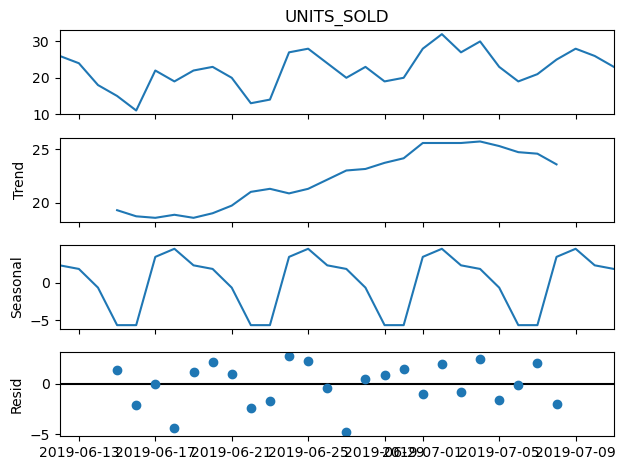

In [ ]:
decomposition = sm.tsa.seasonal_decompose(original_data_train['UNITS_SOLD'][:30], model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
sarima_df = original_data_train['UNITS_SOLD']
model = SARIMAX(sarima_df, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = model.fit()

sarima_fit.summary()

/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07884D+00    |proj g|=  4.64923D-02

At iterate    5    f=  4.01376D+00    |proj g|=  8.47681D-02

At iterate   10    f=  3.96550D+00    |proj g|=  3.04911D-03

At iterate   15    f=  3.96071D+00    |proj g|=  2.00367D-02

At iterate   20    f=  3.95843D+00    |proj g|=  1.32231D-03

At iterate   25    f=  3.95842D+00    |proj g|=  3.84944D-04

At iterate   30    f=  3.95840D+00    |proj g|=  3.11818D-03

At iterate   35    f=  3.95833D+00    |proj g|=  1.14898D-03

At iterate   40    f=  3.95831D+00    |proj g|=  6.91490D-05

At iterate   45    f=  3.95831D+00    |proj g|=  8.20217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        UNITS_SOLD   No. Observations:                  792
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3134.979
Date:                           Tue, 05 Nov 2024   AIC                           6279.957
Time:                                   10:58:24   BIC                           6303.279
Sample:                               06-12-2019   HQIC                          6288.925
                                    - 08-11-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7639      0.030     25.176      0.000       0.704       0.823
ma.L1         -0.9308      0.021    -44.311      0.000      -0.972      -0.890
ar.S.L7        0.0718      0.031      2.331      0.020       0.011       0.132
ma.S.L7       -0.9998      1.333     -0.750      0.453      -3.612       1.613
sigma2       166.7131    220.459      0.756      0.450    -265.379     598.805
===================================================================================
Ljung-Box (L1) (Q):                   4.21   Jarque-Bera (JB):             28821.48
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             1.71
Prob(H) (two-sided):                  0.16   Kurtosis:                        32.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast_val_mean = sarima_fit.get_forecast(steps=len(original_data_val)).predicted_mean

mae = mean_absolute_error(original_data_val['UNITS_SOLD'], forecast_val_mean)
mae

7.927248259178782

In [ ]:
"""
trials = 5
tuner2 = kt.BayesianOptimization(hypermodel=make_rnn, objective='val_mae', max_trials=trials, max_retries_per_trial=0, max_consecutive_failed_trials=trials, overwrite=True, project_name='RNN', seed=47)

rlr2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
es2 = tf.keras.callbacks.EarlyStopping(monitor='val_mae',patience=20, restore_best_weights=True)

tuner2.search(data_train_2, batch_size=batch_size, validation_data=(data_val), callbacks=[es2, rlr2], epochs=100000)

bestmodel2 = tuner2.get_best_models(num_models=1)[0]
best_hp2 = tuner2.get_best_hyperparameters()[0]

print(best_hp2.values)
"""

"\ntrials = 5\ntuner2 = kt.BayesianOptimization(hypermodel=make_rnn, objective='val_mae', max_trials=trials, max_retries_per_trial=0, max_consecutive_failed_trials=trials, overwrite=True, project_name='RNN', seed=47)\n\nrlr2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)\nes2 = tf.keras.callbacks.EarlyStopping(monitor='val_mae',patience=20, restore_best_weights=True)\n\ntuner2.search(data_train_2, batch_size=batch_size, validation_data=(data_val), callbacks=[es2, rlr2], epochs=100000)\n\nbestmodel2 = tuner2.get_best_models(num_models=1)[0]\nbest_hp2 = tuner2.get_best_hyperparameters()[0]\n\nprint(best_hp2.values)\n"

In [ ]:
trials = 1
tuner = kt.BayesianOptimization(hypermodel=make_rnn, objective='val_mae', max_trials=trials, max_retries_per_trial=0, max_consecutive_failed_trials=trials, overwrite=True, project_name='RNN', seed=47)

rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_mae',patience=30, restore_best_weights=True)

tuner.search(data_train, batch_size=batch_size, validation_data=(data_val), callbacks=[es, rlr], epochs=10000)
bestmodel = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters()[0]

print(best_hp.values)

Trial 1 Complete [00h 01m 00s]
val_mae: 5.990628719329834

Best val_mae So Far: 5.990628719329834
Total elapsed time: 00h 01m 00s
{'model_length': 18, 'size': 275, 'dropout_percentage': 0.2, 'learning_rate': 9.887195863122636e-05, 'decay': 0.21916598643840332}


/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
mean_absolute_error(original_data_test['UNITS_SOLD'][:21], sarima_fit.get_forecast(steps=21).predicted_mean)

10.903626441699155

In [ ]:
y_pred = bestmodel.predict(original_data_test.to_numpy()[np.newaxis, :1])[0, -1]
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


array([41.13114 , 41.30733 , 41.25008 , 40.33    , 41.18715 , 41.264366,
       41.16674 , 41.551647, 41.081345, 41.764538, 41.50978 , 41.183693,
       41.874783, 42.004635, 42.256138, 41.962646, 41.840614, 42.31085 ,
       41.934036, 42.27579 , 42.66941 ], dtype=float32)

In [ ]:
mean_absolute_error(original_data_test['UNITS_SOLD'][:21], y_pred)

8.273403894333612

# Funciones generalizadas

In [ ]:
def set_date_vars(df):
    df = df.reset_index()
    df['DAYWEEK'] = df['DATE'].dt.dayofweek
    df['MONTH'] = df['DATE'].dt.month
    df['DAYMONTH'] = df['DATE'].dt.day
    df['LAG_1'] = df['UNITS_SOLD'].shift(1)
    df['LAG_7'] = df['UNITS_SOLD'].shift(7)
    df['LAG_30'] = df['UNITS_SOLD'].shift(30)
    return df.set_index('DATE')

In [ ]:
def make_model(category, df, start_date='2019-06-12', mid_date='2021-08-12', end_date='2021-10-20'):
    trials = 20
    sequence_length = 1
    ahead = 21
    batch_size = 16

    df = df[df['CATEGORY'] == category].drop('CATEGORY', axis=1).sort_values(by='DATE')
    df = df.set_index('DATE')
    df.index = pd.to_datetime(df.index)
    date_diff = df.index.to_series().diff().dt.days
    df = df[(date_diff == 1)]

    df = set_date_vars(df).fillna(0)

    original_data_train = df[(df.index < mid_date) & (df.index >= start_date)]
    original_data_val = df[(df.index < end_date) & (df.index >= mid_date)]
    
    data_train = set_dataset(original_data_train, seq_length=sequence_length, ahead=ahead, batch_size=batch_size, shuffle=False)
    data_val = set_dataset(original_data_val, seq_length=sequence_length, ahead=ahead)

    tuner = kt.BayesianOptimization(hypermodel=make_rnn, objective='val_mae', max_trials=trials, max_retries_per_trial=0, max_consecutive_failed_trials=trials, overwrite=True, project_name='RNN'+category, seed=47)

    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_mae',patience=30, restore_best_weights=True)

    tuner.search(data_train, batch_size=batch_size, validation_data=(data_val), callbacks=[es, rlr], epochs=10000)
    bestmodel = tuner.get_best_models(num_models=1)[0]

    return bestmodel

In [ ]:
def all_models_needed(df, models={}, start_date='2019-06-12', mid_date='2021-08-12', end_date='2021-10-20'):
    for cat in df['CATEGORY'].unique():
        if cat not in models.keys():
            models[cat] = make_model(cat, df, start_date=start_date, mid_date=mid_date, end_date=end_date)

    return models

In [ ]:
def predict(df, models):
    predictions = {}
    for cat in df['CATEGORY'].unique():
        df = df[df['CATEGORY'] == cat].drop('CATEGORY', axis=1).sort_values(by='DATE')
        df = set_date_vars(df)

        pred = models[cat].predict(original_data_test.to_numpy()[np.newaxis, :1])[0, -1]

        predictions[cat] = pred

    return predictions

In [ ]:
models = all_models_needed(df)

Trial 1 Complete [00h 48m 07s]
val_mae: 649.7013549804688

Best val_mae So Far: 649.7013549804688
Total elapsed time: 00h 48m 07s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
50                |18                |model_length
309               |275               |size
0.55              |0.2               |dropout_percentage
1.5159e-05        |9.8872e-05        |learning_rate
0.86933           |0.21917           |decay

Epoch 1/10000


In [ ]:
df_val = df[(df.index < '2021-10-20') & (df.index >= '2021-08-12')].fillna(0)
preds = predict(df_val[0], models)